In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

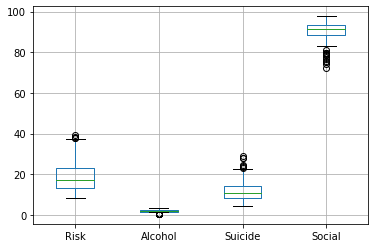

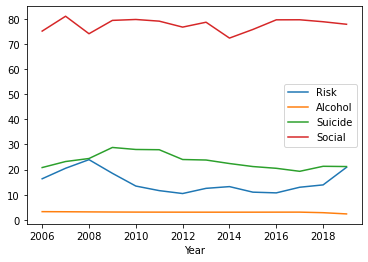

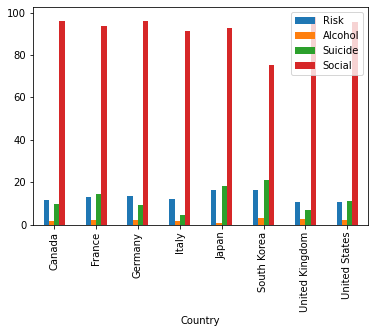

Alcohol: -0.2986015283320355
Suicide: -0.1312161839045365
Social: 0.058699853348999756


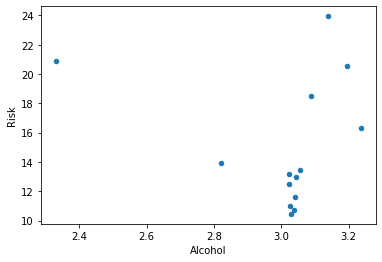

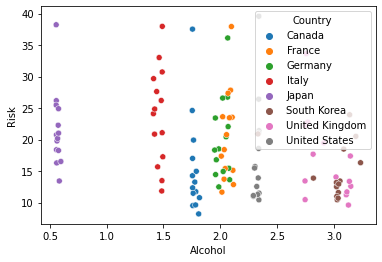

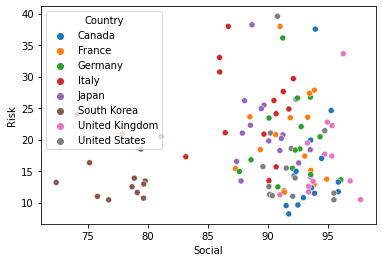

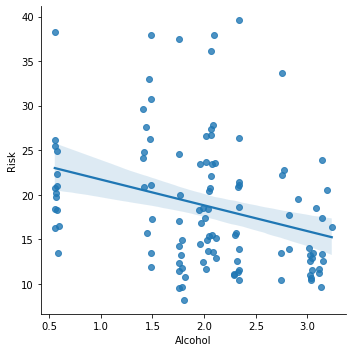

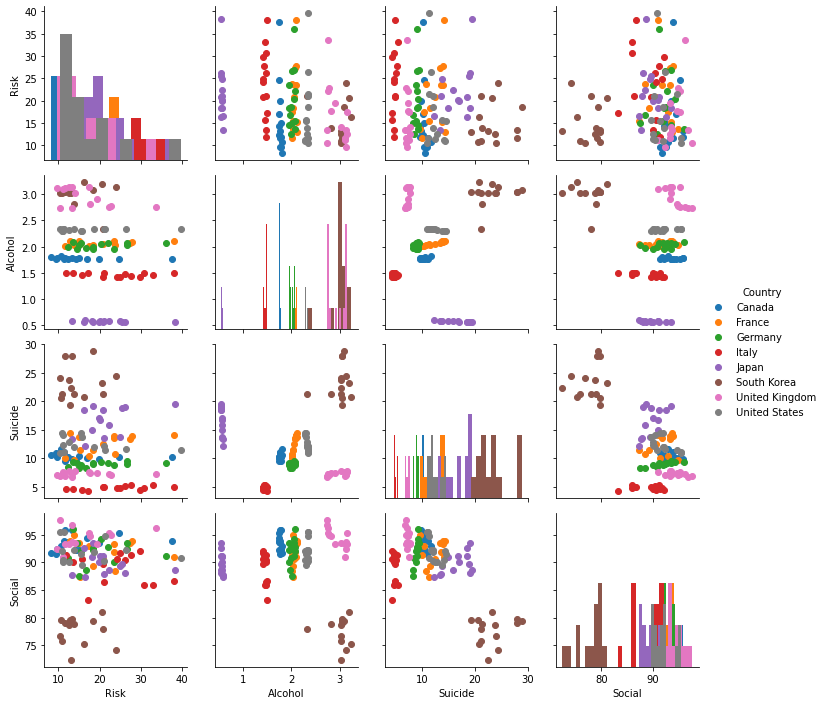

In [2]:
%run Data_Master.ipynb

### Simple Linear Regression

In [3]:
# Simple Linear Regression

def SLR(indep, dep = "Risk", scale = "Y"):
    
    X = df[[indep]]
    y = df[dep]
    
    if scale == "Y":   # Default mode leads to scaling
        scaler = StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X = X_scaled
    
    model = linear_model.LinearRegression()
    model.fit(X,y)
    
    weight = model.coef_
    intercept = model.intercept_
    
    y_pred = model.predict(X)
    r2 = r2_score(df["Risk"], y_pred)
    
    print(f"Regression --- x = {indep.lower()}, y = {dep.lower()}")
    print(f"y = {weight[0]:.2f} x + {intercept:.2f}")
    print("R2:",f"{r2:.5f}")
    print("-------------------------------------------")

In [4]:
for attr in attributes_corr:
    SLR(attr)

Regression --- x = alcohol, y = risk
y = -2.17 x + 18.75
R2: 0.08916
-------------------------------------------
Regression --- x = suicide, y = risk
y = -0.95 x + 18.75
R2: 0.01722
-------------------------------------------
Regression --- x = social, y = risk
y = 0.43 x + 18.75
R2: 0.00345
-------------------------------------------


### Multivariate Linear Regression

In [5]:
# Check correlation

df_corr = df[attributes].corr()
df_corr

,Risk,Alcohol,Suicide,Social
Risk,1.000000,-0.298602,-0.131216,0.058700
Alcohol,-0.298602,1.000000,0.150909,-0.235346
Suicide,-0.131216,0.150909,1.000000,-0.665686
Social,0.058700,-0.235346,-0.665686,1.000000


<AxesSubplot:>

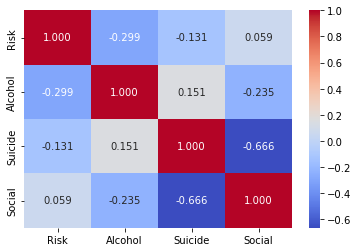

In [6]:
sns.heatmap(df_corr, cmap = "coolwarm",
           annot = True, fmt = ".3f")

Since alcohol, suicide and social are correlated, multivariate linear regression is flawed.

However, we find the regression to get the sketch.

In [7]:
X = df[attributes_corr]
y = df["Risk"]
    
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X = X_scaled
    
model = linear_model.LinearRegression()
model.fit(X,y)
    
weight = model.coef_
intercept = model.intercept_
    
y_pred = model.predict(X)
r2 = r2_score(df["Risk"], y_pred)
    
print(weight, intercept)
print(r2)

[-2.19866469 -1.2253238  -0.90649748] 18.754921749999998
0.10513145335904006


### Principal Component Analysis

In [8]:
def my_PCA(data, dimension=2):
    
    X = data[attributes_corr]
    y = data["Risk"]
    
    # scale attributes before decomposition
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    # principal component analysis
    pca = PCA(n_components=dimension)
    pca.fit(X_scaled)
    attr_pca = pca.transform(X_scaled)

    # construct new DataFrame containing the result of PCA
    col = []
    for i in range(dimension):
        col.append(f"pc_{i+1}")
    df_pca = pd.DataFrame(attr_pca, columns = col)
    df_pca["Risk"] = list(data["Risk"])
    
    # 0: df, 1: explained variance ratio, 2: loading
    return df_pca, pca.explained_variance_ratio_[0], list(pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_))[0])
    

In [9]:
my_PCA(df)

(         pc_1      pc_2      Risk
 0   -1.120122 -0.021598  11.74154
 1   -0.159121 -0.109824  12.86654
 2   -1.048037 -0.416740  13.63169
 3   -1.255714  0.229151  11.84762
 4   -0.232103  2.093638  16.30069
 ..        ...       ...       ...
 107 -0.266462  0.454435  17.27391
 108 -0.285151  1.873017  16.53054
 109  2.744277  0.498276  20.90015
 110 -0.522723 -1.752235  11.70249
 111  0.229435 -0.262901  15.48678
 
 [112 rows x 3 columns],
 0.5878952873311412,
 [0.4504869142851577, 0.8744674243962105, -0.9010789019508123])

In [12]:
# Linear Regression using PC_1

# Enter Mode = "Full" for full stats
def SLR_PCA(Hue, Mode = "Simple"):
    
    hue_list = list(df[Hue].unique())
    weight_list = []
    intercept_list = []
    R2_list = []
    loading_list = []
    
    for i in hue_list:
        
        df_sliced = df[df[Hue]==i]
        result = my_PCA(df_sliced) # initiate PCA
        df_pca = result[0] # call df
        
        if Mode == "Full":
            print(f"{Hue} = {i}")
            print("Expalined Variance Ratio:", result[1])
            print("Loadings:", result[2])
        
        X = df_pca[["pc_1"]]
        y = df_pca["Risk"]
        
        # Linear Regression
        model = linear_model.LinearRegression()
        model.fit(X, y)
        weight = model.coef_
        intercept = model.intercept_
    
        y_pred = model.predict(X)
        r2 = r2_score(df_pca["Risk"], y_pred)
        
        if Mode == "Full":
            print(f"Regression --- x = pc_1, y = risk")
            print(f"y = {weight[0]:.2f} x + {intercept:.2f}")
            print("R2:",f"{r2:.5f}")
            print("-------------------------------------------")
            
        weight_list.append(weight[0])
        intercept_list.append(intercept)
        R2_list.append(r2)
        loading_list.append(result[2])
        
    return hue_list, weight_list, intercept_list, R2_list, loading_list

In [13]:
SLR_PCA("Country")

(['Canada',
  'France',
  'Germany',
  'Italy',
  'Japan',
  'South Korea',
  'United Kingdom',
  'United States'],
 [-2.6722214877140327,
  1.6753082021807881,
  -1.046218222630752,
  0.1986795217996546,
  -1.235670941618951,
  0.09165776987304103,
  1.5723237617194028,
  -1.3836527748724161],
 [15.381143785714286,
  20.654239285714286,
  20.003306428571427,
  23.88868642857142,
  21.554033571428565,
  14.997839285714287,
  16.409173071428572,
  17.150952142857147],
 [0.2137776799866885,
  0.12432715305981767,
  0.06007172373443581,
  0.0011822733927201456,
  0.10645795388440071,
  0.0006153178201226961,
  0.13565785048454615,
  0.07467461216533844],
 [[0.753875324997392, 0.8405424432207618, -0.726146631217225],
  [1.007658858097226, 0.9722574461652214, 0.6077238943744607],
  [-0.6755594825153524, -0.9704832656845617, -0.9700964284867122],
  [0.9374884661988696, -0.04486481745138377, -0.9368309995420921],
  [0.9874824600240305, -0.9936976380543743, -0.7534318211123895],
  [-0.59001723